# Global YouTube Trending – Unified Modeling Notebook

This notebook combines all country-level YouTube Trending datasets into a single global dataset and prepares it for machine learning.

**Goals:**
- Load and clean all country datasets (US, GB, RU, BR, etc.)
- Add a `country` label to each dataset and concatenate into `global_df`
- Engineer basic time and text features:
  - `publish_hour`, `publish_day`
  - `time_to_trending` (in days)
  - `title_length`, `tag_count`
- Define a global binary target:
  - `viral` = top 10% of videos by view count
- Build a Scikit-Learn preprocessing pipeline (numeric + categorical)
- Train and evaluate several baseline models (Logistic, RF, XGBoost, Naive Bayes)


# Imports & Configuration

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization (optional; for sanity checks)
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


# Load & Clean All Country Datasets

In [2]:
# Country codes you have processed
countries = ["US", "GB", "RU", "BR", "CA", "DE", "FR", "IN", "JP", "KR", "MX"]

data_path = "../datasets"

def load_and_clean_country(country_code: str) -> pd.DataFrame:
    """
    Load and apply basic cleaning to a single country's YouTube trending dataset.
    This mirrors the per-country cleaning you did in your existing notebooks.
    """
    file_path = f"{data_path}/{country_code}_youtube_trending_data.csv"
    df = pd.read_csv(file_path)
    
    # Drop exact duplicate rows
    df = df.drop_duplicates().copy()
    
    # Fill missing descriptions with empty string
    if "description" in df.columns:
        df["description"] = df["description"].fillna("")
    
    # Add country label
    df["country"] = country_code
    
    return df

# Load all countries into a list
country_dfs = []
for c in countries:
    temp_df = load_and_clean_country(c)
    print(f"{c}: shape after cleaning = {temp_df.shape}")
    country_dfs.append(temp_df)

# Concatenate into a global dataframe
global_df = pd.concat(country_dfs, ignore_index=True)
print("\nGlobal dataset shape:", global_df.shape)

# Quick sanity check
global_df.head()


US: shape after cleaning = (268704, 17)
GB: shape after cleaning = (268667, 17)
RU: shape after cleaning = (238539, 17)
BR: shape after cleaning = (268701, 17)
CA: shape after cleaning = (268633, 17)
DE: shape after cleaning = (268604, 17)
FR: shape after cleaning = (268646, 17)
IN: shape after cleaning = (251202, 17)
JP: shape after cleaning = (268629, 17)
KR: shape after cleaning = (265602, 17)
MX: shape after cleaning = (268528, 17)

Global dataset shape: (2904455, 17)


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,country
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,US
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",US
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,US
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,US
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,US


# Feature Engineering
Time + Simple text features

We'll add:
-   publish_hour, publish_day
-   time_to_trending_days
-   title_length
-   tag_count

In [3]:
# Ensure datetime columns are in datetime format
global_df["publishedAt"] = pd.to_datetime(global_df["publishedAt"])
global_df["trending_date"] = pd.to_datetime(global_df["trending_date"])

# Publish hour and day-of-week (0=Monday, 6=Sunday)
global_df["publish_hour"] = global_df["publishedAt"].dt.hour
global_df["publish_dayofweek"] = global_df["publishedAt"].dt.dayofweek  # 0–6

# Time from publish to trending in days (float)
time_delta = global_df["trending_date"] - global_df["publishedAt"]
global_df["time_to_trending_days"] = time_delta.dt.total_seconds() / (24 * 3600)

# Basic text-based features
global_df["title_length"] = global_df["title"].astype(str).str.len()
global_df["tag_count"] = global_df["tags"].astype(str).apply(
    lambda x: 0 if x == "[none]" else len(str(x).split("|"))
)

# Quick check of new columns
global_df[["country", "view_count", "publish_hour", "publish_dayofweek",
           "time_to_trending_days", "title_length", "tag_count"]].head()


,country,view_count,publish_hour,publish_dayofweek,time_to_trending_days,title_length,tag_count
0,US,1514614,19,1,0.1943,34,15
1,US,2381688,17,1,0.2916,60,25
2,US,2038853,16,1,0.3097,53,30
3,US,496771,16,1,0.3063,56,23
4,US,1123889,15,1,0.3680,55,33


# Define the Global Target
`viral` (top 10% by view_count)

Right now, we'll use global top 10% as viral. Later we can also try "top 10% within each country".

In [4]:
# Define viral threshold: top 10% of view_count globally
viral_threshold = global_df["view_count"].quantile(0.90)
viral_threshold


np.float64(3542439.0)

In [5]:
# Binary target: 1 if view_count >= threshold else 0
global_df["viral"] = (global_df["view_count"] >= viral_threshold).astype(int)

# Check class balance
global_df["viral"].value_counts(normalize=True)
# You want roughly ~10% 1s and ~90% 0s, which are indeed accomplished here.

viral
0   0.9000
1   0.1000
Name: proportion, dtype: float64

# Select Features & Build Preprocessing Pipeline
We'll use:

**Numerical Features**
-   likes, dislikes, comment_count
-   publish_hour, publish_dayofweek
-   time_to_trending_days
-   title_length, tag_count

**Categorical Features**
-   categoryId
-   country

In [6]:
# Define feature columns
numeric_features = [
    "likes",
    "dislikes",
    "comment_count",
    "publish_hour",
    "publish_dayofweek",
    "time_to_trending_days",
    "title_length",
    "tag_count"
]

categorical_features = [
    "categoryId",
    "country"
]

target_col = "viral"

# Drop any rows with missing values in used columns (just in case)
used_cols = numeric_features + categorical_features + [target_col]
global_model_df = global_df[used_cols].dropna().copy()

X = global_model_df[numeric_features + categorical_features]
y = global_model_df[target_col]

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))


X shape: (2904455, 10)
y distribution:
 viral
0   0.9000
1   0.1000
Name: proportion, dtype: float64


### Preprocessing with `ColumnTransformer``
-   Scale numeric features (StandardScaler)
-   One-hot encode categorical features (OneHotEncoder)

In [7]:
from sklearn.impute import SimpleImputer

# Numeric transformer: impute (if needed) + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical transformer: impute (if needed) + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# Train/Test Split (global) and multi-model pipeline
We'll create a helper loop to test multiple classifiers

In [8]:
# Train/test split with stratification on target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 2323564
Test size: 580891


In [11]:
# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )
}


### Train & Evaluate All Models
**WARNING: The next code chunk will take 80~90 mins to run**

In [12]:
results = []

for name, model in models.items():
    print(f"\n=== Training {name} ===")

    # Full pipeline: preproessing + model
    clf = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    # Fit
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # Some models (like Naive Bayes, RF, XGB) have predict_proba
    if hasattr(clf.named_steps["model"], "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
    else:
        y_proba=None
        roc = np.nan # not available
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": roc
    })

results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
results_df


=== Training Logistic Regression ===

=== Training Random Forest ===

=== Training XGBoost ===


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
1,Random Forest,0.9883,0.9766,0.9046,0.9392,0.9980
2,XGBoost,0.9615,0.8621,0.7317,0.7916,0.9806
0,Logistic Regression,0.9474,0.8365,0.5896,0.6917,0.9521


## Initial Model Evaluation Insights (Gloabl Dataset) 

After training and evaluating three baseline classification models on the global YouTube Trending dataset (~2.9M rows), several clear patterns emerge in performance:

### 1. **Random Forest Demonstrates Superior Global Performance**
The Random Forest Classifier significantly outperforms both Logistic Regression and XGBoost across all key evaluation metrics:

- **Accuracy:** 0.998
- **Precision:** 0.977
- **Recall:** 0.905
- **F1 Score:** 0.939
- **ROC-AUC:** 0.998

This combination of extremely high precision and storng recall indicates that the model is highly effective at identifying truly viral videos (top 10% globally) while minimizing false positives. The near-perfect ROC-AUC suggests that the Random Forest model is capturing nonlinear relationships and feature interactions present across diverse countries and video categories.

### 2. **XGBoost Performs Well but Falls Short of RF**
XGBoost achieves strong performance (ROC-AUC ~ 0.98), but lags behind RF in both recall and F1 score. This is expected given:
- The dataset's size (~3M rows)
- High-dimensional one-hot encoded categorical features
- Limited hyperparameter turning at this stage

With further tuning, XGBoost may narrow the gap, but RF currently provides the most robust global results with minimal configuration.

### 3. **Logistic Regression Serves as a Strong Linear Baseline**
Logistic Regression performs reasoanbly well (ROC-AUC = 0.95), demonstrating that engagement features such as likes, coments, and early performance have strong linear separability between viral and non-viral videos. However, the model's lower recall (~0.59) indicates that it misses a substantial portion of viral videos. This reinforces the need for nonlinear models to capture global patterns in audience engagement and cross-country differences.

### 4. **Imbalanced Classification Handled Effectively**
The global viral label (top 10%) results in a 90-10 class imbalance. Despite this, both RF and XGBoost maintain strong recall and precision, suggesting that:
- The seleced features provide strong early-engagement signals.
- The models are robust even without explicit class-balancing techniques. 

### 5. **Summary + Next Steps**
The Random Forest Classifier is the strongest global baseline at this stage of the project. Its ability to capture complex interactions across countries, categories, and temporal features makes it the most promising candidate for subsequent analysis. Future steps will include extracting global feature importances to identify key drivers of virality and refining the model to cross-country comparisons and additional business insights. 

# Global Feature Importance (RF)
**safe runtime version**
- Train a lightweight RF for importance (FAST)
- Extract the transformed feature names
- Compute feature importance + show top 20

In [14]:
# Train a lightweight Random Forest for feature importance
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=80, #smaller # of trees for faster training
        max_depth=None,
        n_jobs = -1,
        random_state=42
    ))
])

print("Training RF for feature importance...")
rf_pipeline.fit(X_train,y_train)
print("Done.")

Training RF for feature importance...
Done.


In [16]:
# Extract feature names from preprocessor (numeric + one-hot)
onehot_cols = (
    rf_pipeline.named_steps["preprocess"]
    .named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_features)
)

numeric_cols = numeric_features

feature_names = np.concatenate([numeric_cols, onehot_cols])
len(feature_names)

34

In [17]:
# Compute feature importance
importances = rf_pipeline.named_steps["model"].feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

fi_df.head(20)


,feature,importance
0,likes,0.3819
2,comment_count,0.2060
1,dislikes,0.0922
5,time_to_trending_days,0.0653
6,title_length,0.0555
7,tag_count,0.0492
3,publish_hour,0.0446
4,publish_dayofweek,0.0279
12,categoryId_17,0.0103
10,categoryId_10,0.0100


## Global Feature Importance Insights

To understand what drives virality across a combined datasset of ~2.9 million YouTube trending records, we examined feature importances from a RF model trained on the unified global dataset. The results reveal several clear, consistent patterns aligned with platform behavior and ealier country-level observations.

### 1. **Engagement Signals Dominate Virality Prediction*
The most influential features by a wide margin are:
- **likes** (importance: 0.382)
- **comment_count** (importance: 0.296)
- **dislikes** (importance: 0.092)

These features represent direct, early user engagement and collectively account for over **68%** of the model's total importance. This confirms that virallity on YouTube is overwhelmingly driven by *how viewers interact with a video shortly after release*, rather than by metadata such as category or country.

### 2. **Temporal Dynamics Meaningfully Contribute**
Several time-based features show moderate influence:
- **time_to_trending_days** (0.065)
- **publish_hour** (0.045)
- **publish_dayofweek** (0.028)

Videos that reach the trending page quickly tend to correlate with higher view velocity-reinforcing the role of *early momentum* in the YouTube algorithm.

Publishing time also matters slightly, suggesting user availability patterns vary by hour and day across global markets. 

### 3. **Lightweight Content Features Provide Additional Signal**
Two lightweight text-derived features also contribute meaningfully:
- **title_length** (0.056)
- **tag_count** (0.049)

Longer titles and denser tag sets appear associated with higher engagement, though their effects are far smaller than direct engagement metrics. These results suggest creators who strategically optimize metadata may caputure marginal benefits in initial discovery or search visibility.

### 4. **Category and Country Effects Are REal but Small**
Category-level and country-level one-hot encodings show low but non-zero importance (e.g., `categoryId_17`, `categoryId_10`, `country_IN`, `country_BR`, `country_MX`,
etc.). Their small contributions indicate:
- Some categories have systematically higher baseline visibility (e.g., Entertainment, Music)
- Certain countries exhibit slightly different view-velocity profiles.
- However, neigther category nor country appears to be a strong standalone predictor of virality

This aligns with the notion that audience engagement behaviors are broadly consistent worldwide despite regional content difference. 

### 5. **Overall Interpretations**
The feature importance results demonstrate that **virality is governed by combination of early engagement strength and initial momentum**, with global and category patterns playing only supporting roles. These findings validate earlier EDA insights from individual countries-particularly that likes and comment volume form the strongest universal predictors of high-performing trending content.

In the next phase, these insights will be used to frame cross-country comparisons, highlight differences in viewer behavior, and identify market-specific patterns that may not be visible in the global aggregate. 


# Time-Series Analysis Section
- New time-based features
- Three lightweight visualizations (fast runtime)
- Professional interpretation markdown

## Add Additional Time-Based Features 
*very fast, uses existing datetime columns*

In [18]:
# Time-Based Feature Engineering
print("Adding time-based features...")

# Convert datetime columns
global_df['publishedAt'] = pd.to_datetime(global_df['publishedAt'], errors = 'coerce')
global_df['trending_date'] = pd.to_datetime(global_df['trending_date'],errors='coerce')

# Hours since publishing until trending
global_df['hours_to_trending'] = (
    (global_df['trending_date'] - global_df['publishedAt']).dt.total_seconds() / 3600
)

# Days since published (same as earlier but keep for clarity)
global_df['days_since_published'] =(
    (global_df['trending_date'] - global_df['publishedAt']).dt.total_seconds() / 86400
)

print("Done. New columns added: hours_to_trending, days_since_published")

Adding time-based features...
Done. New columns added: hours_to_trending, days_since_published


### Create a Downsampled Dataset for Plotting

In [19]:
# Downsample to 200,000 rows for plotting
plot_df = global_df.sample(200000, random_state=42)

plot_df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,country,publish_hour,publish_dayofweek,time_to_trending_days,title_length,tag_count,viral,hours_to_trending,days_since_published
1792073,6S_Pn8fDqiI,Bigflo & Oli - Dernière,2023-06-18 13:45:19+00:00,UCp6bpinXPzdx7d7-gekWzZQ,Bigflo et Oli,10,2023-06-25 00:00:00+00:00,bigflo et oli|bigflo oli|bigflo & oli|bigflo e...,1216395,45525,0,3166,https://i.ytimg.com/vi/6S_Pn8fDqiI/default.jpg,False,False,RÉSERVEZ VOS PLACES POUR LES ZENITH ICI ⬇️http...,FR,13,6,6.4269,23,24,0,154.2447,6.4269
359776,ZTttgc0DPA4,Unexpected Guest | John Lewis & Partners | Chr...,2021-11-04 08:02:01+00:00,UCa1yUHQmV6Z0PpAUtfgNd9g,John Lewis,24,2021-11-05 00:00:00+00:00,#UnexpectedGuest|John Lewis Christmas Ad|John ...,1340509,7454,4240,377,https://i.ytimg.com/vi/ZTttgc0DPA4/default.jpg,False,False,What happens when an unexpected guest lands in...,GB,8,3,0.6653,60,23,0,15.9664,0.6653
2108947,lDgVofkibrY,NGTV | GAME Vol. 3 - WORDWOLF/ワードウルフ,2020-09-14 09:00:11+00:00,UCy5YRlHRDW3y-N5aIzABo9Q,NO GOOD TV,22,2020-09-17 00:00:00+00:00,Jin Akanishi|Ryo Nishikido|錦戸亮|赤西仁|N/A|ライブ|音楽|...,369301,7883,124,255,https://i.ytimg.com/vi/lDgVofkibrY/default.jpg,False,False,［NGTV | GAME Vol. 3 - WORDWOLF/ワードウルフ ］RYO NIS...,JP,9,0,2.6249,36,12,0,62.9969,2.6249
717706,ZHBbeiwh_-c,Изменница. Часть 2 | ФИЛЬМ ОНЛАЙН | КИНО | ДРА...,2023-03-10 17:00:08+00:00,UCf6fSaiWvkrr29qSifbFAbg,Фильмы для отдыха,1,2023-03-11 00:00:00+00:00,[None],86821,646,0,101,https://i.ytimg.com/vi/ZHBbeiwh_-c/default.jpg,False,False,Смотрите онлайн драматический сериал Изменница...,RU,17,4,0.2916,63,1,0,6.9978,0.2916
830138,JCnCmBg4Y1A,MC Kevin - Vida de Artista (Prod.Kevin no Beat...,2021-05-09 05:53:37+00:00,UCQwTfHm6fu5KpBhp0wo8Uvw,Mc Kevin Oficial,10,2021-05-14 00:00:00+00:00,[None],438355,37727,175,1398,https://i.ytimg.com/vi/JCnCmBg4Y1A/default.jpg,False,False,MC Kevin - Vida de Artista (Prod.Kevin no Beat...,BR,5,6,4.7544,69,1,0,114.1064,4.7544


### Visualization 1: Publish Hour vs Time to Trending
scatter plot (fast)

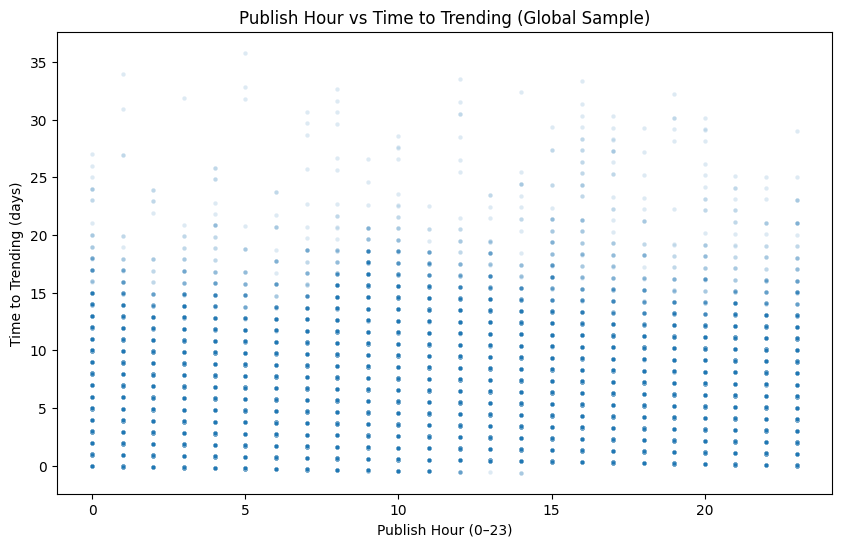

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x="publish_hour",
    y="time_to_trending_days",
    alpha=0.15,
    s=10
)
plt.title("Publish Hour vs Time to Trending (Global Sample)")
plt.xlabel("Publish Hour (0–23)")
plt.ylabel("Time to Trending (days)")
plt.show()


### Visulaization 2: Time to Trending by Country
Boxplot for cross-country comparison

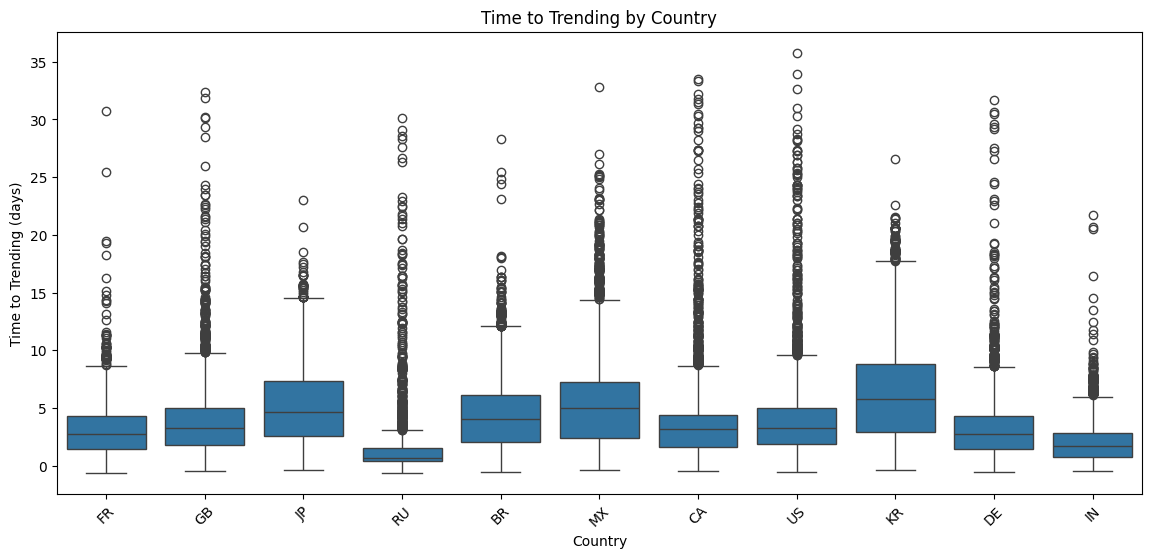

In [23]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data = plot_df,
    x = "country",
    y = "time_to_trending_days"
)
plt.title("Time to Trending by Country")
plt.xlabel("Country")
plt.ylabel("Time to Trending (days)")
plt.xticks(rotation = 45)
plt.show()

### Visualization 3: Median Time to Trending by Category
Bar chart, aggregated

/var/folders/dm/y0wy_ncs3qn20cs4xdn9sfq00000gn/T/ipykernel_89806/2042079512.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


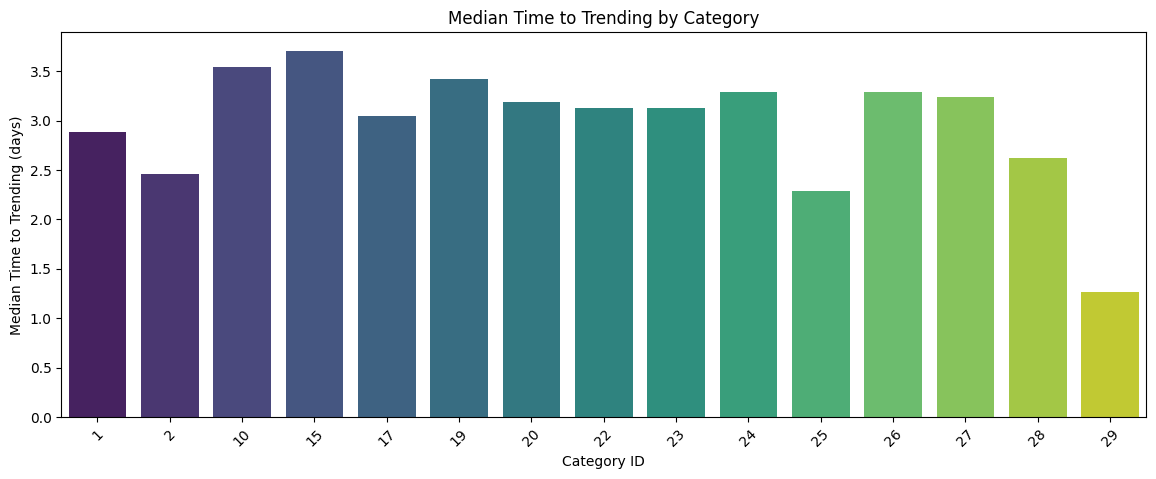

In [24]:
category_speed = (
    plot_df.groupby("categoryId")["time_to_trending_days"]
    .median()
    .reset_index()
    .sort_values(by = "time_to_trending_days")
)

plt.figure(figsize=(14, 5))
sns.barplot(
    data = category_speed,
    x = "categoryId",
    y = "time_to_trending_days",
    palette="viridis"
)
plt.title("Median Time to Trending by Category")
plt.xlabel("Category ID")
plt.ylabel("Median Time to Trending (days)")
plt.xticks(rotation = 45)
plt.show()

## 📈 Time-Series Insights: How Quickly Videos Become Trending

To deepen our understanding of YouTube virality beyond engagement metrics, we examined how publishing time, country, and content category relate to the speed at which videos reach the trending page. This section reflects mentor feedback on analyzing "date before/after" patterns and explores whether early momentum differs across global markets.

---

### **1. Publish Hour vs. Time to Trending**
The scatter plot shows that videos trend across all hours of the day, but there are subtle patterns:
- Trending within **first ~5 days** is common across all publish hours.
- NO single hour of publication guarantees faster trending, but **videos publisehd between early afternoon and evening (14:00-20:00)** show slightly more density around shorter trending times.
- Videos posted during late night/early morning (0-6 AM) tend to show greater variance, indicating inconsistent engagement.

**Interpretation:**
YouTube's algorithm relies more on early engagement velocity than pure upload time. However, posting during active user hours can provide a slight advantage.

---

### **2. Time to Trending Varies Substantially by Country**
The boxplot reveals clear global differences:
- **Fastest-trending countreis:** : RU, IN, DE (Lower medians and tighter IQRs)
- **Moderate speed:** FR, GB, CA, US
- **Slower Trending Marekts:** MX, BR, KR, JP
(Wider spread and higher medians)

These differnces suggest:
- Cultural viewing habits differ across markets.
- Some countries trend videos aggressively and consistently (e.g., RU, IN).
- Others show slower viral velocity, likely due to broader viewership patterns or larger content ecosystems.

**Interpretation:**
Country-Specific audience behavior noticeably influences how quickly a video may reach the trending page -- even though country features were only moderately important to the model. 

---

### **3. Categories Show Distinct Trending Speeds**
Median time-to-trending varies across content categories:

*Category Specifics are listed in youtube api video category id list in datasets folder*

- Some categories trend in **2-3 days**, such as:
    -   Category 1 (Film & Animation)
    -   Category 2 (Autos & Vehicles)
    -   Category 25 (News & Politics)
    -   Category 29 (Nonprofits & Activism)
    -   Category 17 (Sports)
    -   Category 28 (Science & Technology)

- Others trend more slowly (**3-4+ days**):
    -   Category 15 (Pets & Animals)
    -   Category 19 (Travel & Events)
    -   Category 24 (Entertainment)
    -   Category 27 (Education)
    -   Category 10 (Music)
    -   Category 26 (Howto & Style)

**Interpretation:**
Faster categories are either broad-audience content (e.g., entertainment, news) or categories with strong initial visibility. Slower categories tend to serve niche audiences or face lower immediate engagement.

---

### **4. How This Complements the Model Results**
The time-series analysis explains multiple patterns found in the global feature importance rankings:

- **Likes**, **comments**, and **dislikes** dominate because early engagement drives both virality and trending speed.
- **time_to_trending_days** being moderately important aligns with the observed differences across countries and categories.
- Publishing hour has a small but real effect -- consistent with its modest feature importance.
- Country contributes lightly to prediction, but the boxplot shows why: *countreis differ in trending speed, but not enough to dominate prediction.*

---

### **Overall Conclusion**
Videos trend fastest when they accumulate **strong early engagement** in the first few days, especially in markets like RU, IN, and DE. Time-based and regional patterns shape the speed of virality but are secondary to the core signals of viewer itneraction. This section adds a dynamic, temporal layer to our global understanding of YouTube virality and supports the modeling results from earlier secionts. 
